# Inference using HuggingFace Transformers

In [1]:
from dataclasses import dataclass
from typing import List
from typing import Tuple

import numpy as np
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("under-tree/transformer-en-ru")
model = AutoModelForSeq2SeqLM.from_pretrained("under-tree/transformer-en-ru")

In [2]:
@dataclass
class TranslationResult:
    input_text: str
    n_input: int
    input_tokens: List[str]
    n_output: int
    output_text: str
    output_tokens: List[str]
    output_scores: List[List[Tuple[str, float]]]
    cross_attention: np.ndarray

In [3]:
def translator_fn(input_text: str, k=10) -> TranslationResult:
    # Preprocess input
    inputs = tokenizer(input_text, return_tensors="pt")
    input_tokens = tokenizer.batch_decode(inputs.input_ids[0])
    input_special_mask = torch.tensor([1 if t in tokenizer.all_special_tokens else 0 for t in input_tokens])

    # Generate output
    outputs = model.generate(**inputs, return_dict_in_generate=True, output_scores=True, output_attentions=True)
    output_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    output_tokens = tokenizer.batch_decode(outputs.sequences[0])
    output_special_mask = torch.tensor([1 if t in tokenizer.all_special_tokens else 0 for t in output_tokens])

    # Get cross attention matrix
    cross_attention = torch.stack([torch.stack(t) for t in outputs.cross_attentions])
    attention_matrix = cross_attention.mean(dim=4).mean(dim=3).mean(dim=2).mean(dim=1).detach().cpu().numpy()

    # Get top tokens
    top_scores = []
    len_input = len(input_tokens)
    len_output = len(output_tokens)

    for i in range(len_output - 1):
        if i + 1 < len_output and output_special_mask[i + 1] == 1:
            # Skip special tokens (e.g. </s>, <pad>, etc.)
            continue
        top_elements, top_indices = outputs.scores[i].mean(dim=0).topk(k)
        top_elements = top_elements.exp()
        top_elements /= top_elements.sum()

        top_indices = tokenizer.batch_decode(top_indices)

        # filter out special tokens
        top_pairs = [(m, t.item()) for t, m in zip(top_elements, top_indices) if m not in tokenizer.all_special_tokens]
        top_scores.append(top_pairs)

    # Filter out special tokens from all elements
    clean_output_tokens = [t for t, m in zip(output_tokens, output_special_mask) if m == 0]
    clean_input_tokens = [t for t, m in zip(input_tokens, input_special_mask) if m == 0]
    clean_attention_matrix = attention_matrix[:len_output, :len_input]  # for padding
    clean_attention_matrix = np.delete(clean_attention_matrix, np.where(output_special_mask == 1), axis=0)
    clean_attention_matrix = np.delete(clean_attention_matrix, np.where(input_special_mask == 1), axis=1)
    
    n_input = len(clean_input_tokens)
    n_output = len(clean_output_tokens)

    assert clean_attention_matrix.shape == (n_output, n_input)
    assert len(top_scores) == n_output
    return TranslationResult(
        input_text=input_text,
        n_input=n_input,
        input_tokens=clean_input_tokens,
        output_text=output_text,
        n_output=n_output,
        output_tokens=clean_output_tokens,
        output_scores=top_scores,
        cross_attention=clean_attention_matrix
    )

## Example

In [4]:
input_text = "Bremen, a vibrant city in Germany, offers a captivating experience for travelers. Explore the historic city center, home to iconic landmarks like the Bremen Town Musicians statue. Wander the charming narrow streets, visit the famous Schnoor quarter, and indulge in delicious local cuisine. Bremen is a must-visit destination for culture and history enthusiasts."

In [5]:
outputs = translator_fn(input_text)

In [6]:
print(outputs.output_text)

Бремен, живой город в Германии, предлагает захватывающий опыт для путешественников. Изучение исторического центра города, где находятся иконные достопримечательности, такие как статуя бременовских таун-музыкантов. Заглядывая в очаровательные узкие улицы, посещая знаменитый квартал Шнура и получая вкусную местную кухню. Бремен является необходимым местом для посещения культурно-исторических энтузиастов.


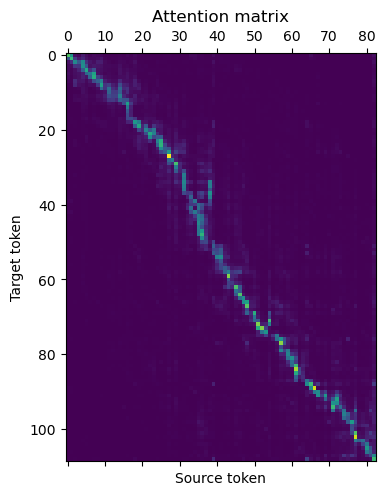

In [7]:
plt.matshow(outputs.cross_attention)
plt.xlabel("Source token")
plt.ylabel("Target token")
plt.title("Attention matrix")
plt.show()

In [8]:
print("Top tokens (synonyms) with scores:")
for i, (token, scores) in enumerate(zip(outputs.output_tokens, outputs.output_scores)):
    if i >= 10:
        break
    print(f"{i + 1}. {token}")
    if scores is None:
        continue
    for token, score in scores:
        print(f"\t{token}: {score:.3f}")

Top tokens (synonyms) with scores:
1. Бре
	Бре: 0.825
	Б: 0.117
	B: 0.020
	Брат: 0.010
	Бра: 0.009
	В: 0.006
	Бри: 0.004
	Бе: 0.004
	Ре: 0.002
	Кра: 0.002
2. мен
	мен: 0.446
	ре: 0.154
	м: 0.085
	ман: 0.069
	мена: 0.059
	реш: 0.057
	рен: 0.035
	е: 0.035
	рэ: 0.034
	ем: 0.026
3. ,
	,: 0.589
	мен: 0.114
	м: 0.098
	-: 0.075
	men: 0.026
	(: 0.026
	мена: 0.022
	: 0.021
	-: 0.018
	ман: 0.012
4. жив
	жив: 0.308
	: 0.218
	активный: 0.146
	динамичны: 0.080
	активно: 0.048
	живо: 0.045
	бур: 0.043
	богатый: 0.041
	-: 0.036
	оживлен: 0.035
5. ой
	й: 0.210
	: 0.199
	город: 0.141
	ущий: 0.122
	ый: 0.081
	и: 0.063
	в: 0.055
	ющий: 0.045
	ший: 0.044
	г: 0.039
6. город
	город: 0.671
	в: 0.214
	г: 0.044
	немецки: 0.019
	города: 0.012
	центр: 0.011
	: 0.010
	по: 0.009
	городской: 0.005
	из: 0.005
7. в
	Германии: 0.909
	в: 0.085
	ок: 0.001
	Германия: 0.001
	г: 0.001
	немецко: 0.001
	немецки: 0.000
	ец: 0.000
	,: 0.000
	Г: 0.000
8. Германии
	,: 0.702
	Германии: 0.222
	г: 0.027
	: 0.012
	.: 0.010
	(: 0.007